In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertForSequenceClassification,BertTokenizer
from datasets import load_dataset,DatasetDict
from torch.utils.data import Dataset,DataLoader
from peft import get_peft_model, PromptTuningConfig, LoraConfig,PromptTuningInit, TaskType
from torch.optim import AdamW

device="cuda" if torch.cuda.is_available() else "cpu"

In [3]:

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Load dataset
dataset = load_dataset("imdb")
new_dataset = DatasetDict({
    "train": dataset["train"],
    "val": dataset["test"].shuffle(seed=42).select(range(5000))
})

num_virtual_tokens = 30
max_input_len_soft = 512 - num_virtual_tokens  # since model dim is 512 and 30 are soft prompts
max_input_len_lora=512

# Preprocessing for soft function
def preprocess_bert_soft(dataset):
    input_text = ["classify sentiment: " + t for t in dataset["text"]]
    inputs = tokenizer(input_text, max_length=max_input_len_soft, truncation=True, padding="max_length")
    labels = dataset["label"]
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }
# Preprocessing for lora  function
def preprocess_bert_lora(dataset):
    input_text = ["classify sentiment: " + t for t in dataset["text"]]
    inputs = tokenizer(input_text, max_length=max_input_len_lora, truncation=True, padding="max_length")
    labels = dataset["label"]
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels
    }

token_dataset_soft = new_dataset.map(preprocess_bert_soft, batched=True, remove_columns=new_dataset["train"].column_names)
token_dataset_lora = new_dataset.map(preprocess_bert_lora, batched=True, remove_columns=new_dataset["train"].column_names)


# Create PyTorch dataset
class ImdbDataset(Dataset):
    def __init__(self, token_dataset):
        self.input_ids = torch.tensor(token_dataset["input_ids"], dtype=torch.long)
        self.attention_mask = torch.tensor(token_dataset["attention_mask"], dtype=torch.long)
        self.labels = torch.tensor(token_dataset["labels"], dtype=torch.long)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

# Datasets & dataloaders FOR SOFT
tokens_train_soft = token_dataset_soft["train"]
tokens_val_soft = token_dataset_soft["val"]

train_dataset_soft = ImdbDataset(tokens_train_soft)
val_dataset_soft = ImdbDataset(tokens_val_soft)

train_loader_soft = DataLoader(train_dataset_soft, batch_size=32, shuffle=True)
val_loader_soft = DataLoader(val_dataset_soft, batch_size=64, shuffle=False)

# Datasets & dataloaders for LORA
tokens_train_lora = token_dataset_lora["train"]
tokens_val_lora = token_dataset_lora["val"]

train_dataset_lora = ImdbDataset(tokens_train_lora)
val_dataset_lora = ImdbDataset(tokens_val_lora)

train_loader_lora = DataLoader(train_dataset_lora, batch_size=32, shuffle=True)
val_loader_lora = DataLoader(val_dataset_lora, batch_size=64, shuffle=False)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [4]:


peft_config = PromptTuningConfig(
    peft_type="PROMPT_TUNING",
    task_type="SEQ_CLS",  # for classification
    num_virtual_tokens=30,
    token_dim=model.config.hidden_size,  # use hidden_size for BERT
)

model_soft=BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model_soft = get_peft_model(model_soft, peft_config)


lora_config = LoraConfig(
    r=8,                   # rank of LoRA matrices
    lora_alpha=32,         # scaling factor
    target_modules=["query", "value"],  # BERT attention modules
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"    # classification
)
model_lora=BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

model_lora = get_peft_model(model_lora, lora_config)



optimizer_soft = AdamW(model_soft.parameters(), lr=3e-6, weight_decay=0)
grad_clip = 1.0

optimizer_lora = AdamW(model_lora.parameters(), lr=5e-5, weight_decay=0)
grad_clip = 1.0



def model_train(model,device,train_loader,val_loader,num_epochs,optimizer,grad_clip=None):
    model=model.to(device)
    train_losses=[]
    val_losses=[]
    train_epoch_losses=[]
    val_epoch_losses=[]


    for epoch in range(num_epochs):
        print(f"epoch: {epoch+1}/{num_epochs}")
        model.train()
        running_val_loss=0
        running_train_loss=0
        for train_step, batch in enumerate(train_loader):



            optimizer.zero_grad()
            input_ids=batch["input_ids"]
            attn_mask=batch["attention_mask"]
            labels=batch["labels"]
            output=model(input_ids=input_ids.to(device),
                        attention_mask=attn_mask.to(device),
                        labels=labels.to(device))

            loss=output.loss
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()
            running_train_loss += loss.item()
            if(train_step%100==0):
                train_losses.append(loss.item())

                print(f"train_loss as step {train_step} : {loss.item()}")



        train_avg_loss=running_train_loss/len(train_loader)
        train_epoch_losses.append(train_avg_loss)
        print(f"train_loss for epoch {epoch}:{train_avg_loss}")
        model.eval()

        with torch.no_grad():
            for val_step,batch in enumerate(val_loader):

                input_ids=batch["input_ids"]
                attn_mask=batch["attention_mask"]
                labels=batch["labels"]
                output=model(input_ids=input_ids.to(device),
                            attention_mask=attn_mask.to(device),
                            labels=labels.to(device))
                loss=output.loss


                running_val_loss +=loss.item()


                if(val_step%20==0):
                    val_losses.append(loss.item())
                    print(f"val_loss as step {val_step} : {loss.item()}")
            val_avg_loss= running_val_loss/len(val_loader)
            val_epoch_losses.append(val_avg_loss)

            print(f"val loss for epoch {epoch} : {val_avg_loss}")

    return {
        "train_step_losses": train_losses,
        "train_epoch_losses": train_epoch_losses,
        "val_step_losses": val_losses,
        "val_epoch_losses": val_epoch_losses
    }




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import matplotlib.pyplot as plt



def plot_losses(result):
    # --- Step-wise loss plot ---
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(result["train_step_losses"], label="Train Step Loss", alpha=0.7)
    plt.plot(result["val_step_losses"], label="Val Step Loss", alpha=0.7)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Step-wise Loss")
    plt.legend()
    plt.grid(True)

    # --- Epoch-wise loss plot ---
    plt.subplot(1,2,2)
    plt.plot(result["train_epoch_losses"], marker="o", label="Train Epoch Loss", alpha=0.7)
    plt.plot(result["val_epoch_losses"], marker="o", label="Val Epoch Loss", alpha=0.7)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Epoch-wise Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()





In [6]:
device

'cuda'

In [ ]:
soft_prompt_results=model_train(model_soft,device=device,train_loader=train_loader_soft,val_loader=val_loader_soft,num_epochs=4,optimizer=optimizer_soft,grad_clip=1.0)



epoch: 1/4
train_loss as step 0 : 0.7209523916244507
train_loss as step 100 : 0.7747623324394226
train_loss as step 200 : 0.703554630279541
train_loss as step 300 : 0.6938401460647583
train_loss as step 400 : 0.6784454584121704
train_loss as step 500 : 0.6875702142715454
train_loss as step 600 : 0.6763004064559937
train_loss as step 700 : 0.6881098747253418
train_loss for epoch 0:0.7014568589075142
val_loss as step 0 : 0.6855858564376831
val_loss as step 20 : 0.6934585571289062
val_loss as step 40 : 0.6908600330352783
val_loss as step 60 : 0.6842015981674194
val loss for epoch 0 : 0.6922726284099531
epoch: 2/4
train_loss as step 0 : 0.6784232258796692
train_loss as step 100 : 0.6773864030838013
train_loss as step 200 : 0.6895198225975037
train_loss as step 300 : 0.7134368419647217
train_loss as step 400 : 0.6926062107086182
train_loss as step 500 : 0.6648671627044678
train_loss as step 600 : 0.6906555891036987
train_loss as step 700 : 0.7101597189903259
train_loss for epoch 1:0.6942872

In [ ]:

model_soft.save_pretrained("/content/drive/MyDrive/soft_prompt_adapter")



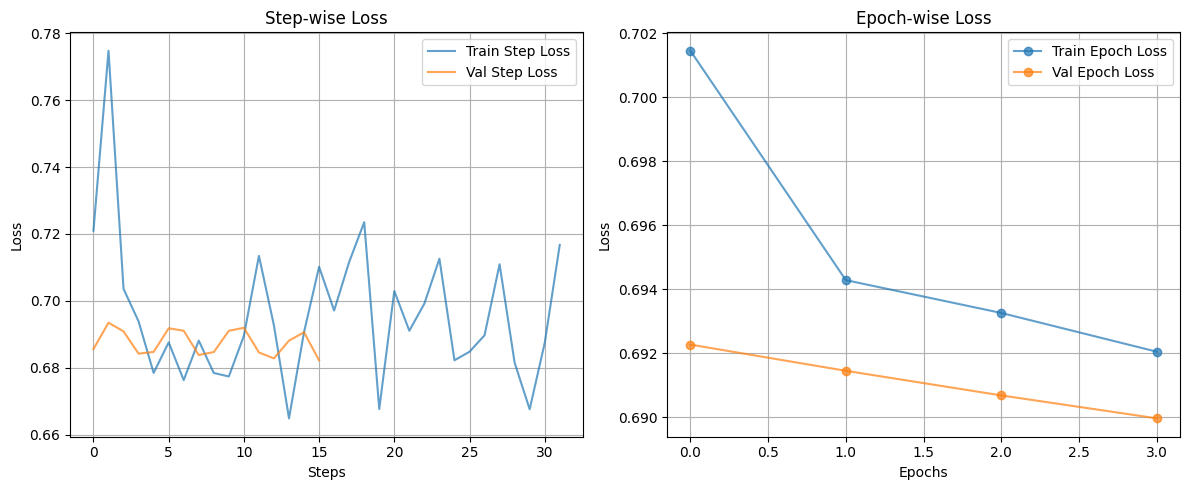

In [ ]:

plot_losses(soft_prompt_results)

In [7]:
lora_results=model_train(model_lora,device=device,train_loader=train_loader_lora,val_loader=val_loader_lora,num_epochs=4,optimizer=optimizer_lora,grad_clip=1.0)

epoch: 1/4
train_loss as step 0 : 0.7560724020004272
train_loss as step 100 : 0.6878339052200317
train_loss as step 200 : 0.38690364360809326
train_loss as step 300 : 0.2038000375032425
train_loss as step 400 : 0.24366623163223267
train_loss as step 500 : 0.36755990982055664
train_loss as step 600 : 0.21153128147125244
train_loss as step 700 : 0.15493565797805786
train_loss for epoch 0:0.3701056206641752
val_loss as step 0 : 0.15766294300556183
val_loss as step 20 : 0.20740815997123718
val_loss as step 40 : 0.4052978754043579
val_loss as step 60 : 0.1744966208934784
val loss for epoch 0 : 0.22571835082165803
epoch: 2/4
train_loss as step 0 : 0.17254285514354706
train_loss as step 100 : 0.27347785234451294
train_loss as step 200 : 0.2881568670272827
train_loss as step 300 : 0.19361577928066254
train_loss as step 400 : 0.40873056650161743
train_loss as step 500 : 0.29978147149086
train_loss as step 600 : 0.33740705251693726
train_loss as step 700 : 0.2550906538963318
train_loss for epoch

In [8]:
model_lora.save_pretrained("/content/my_lora_adapter")

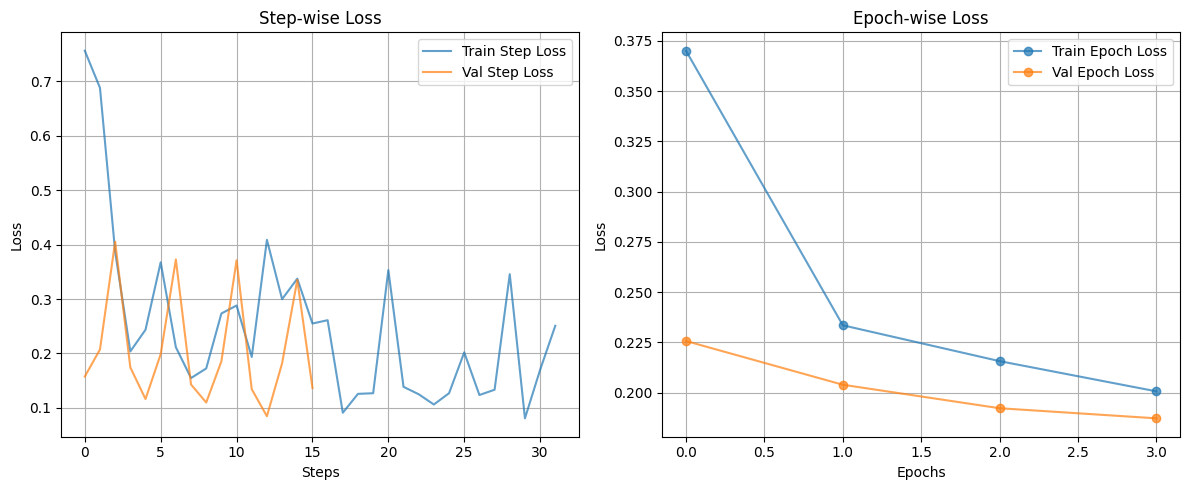

In [11]:

plot_losses(lora_results)

In [12]:
# Copy the entire folder to Drive (into MyDrive)
!cp -r /content/my_lora_adapter /content/drive/MyDrive/